In [1]:
import jax.numpy as jnp


from persistent_storage import (
    get_value,
    experiment_setup,
    build_experiment_name,
)
import itertools
from matplotlib import pyplot as plt


def hex_to_rgb(hex: str):
    return jnp.clip(
        jnp.array([int(hex[i : i + 2], 16) for i in (0, 2, 4)]) * 2 / 255, 0, 1
    ).tolist()


setup_data = experiment_setup["heat and tanh"]
dbname, priors, derivatives, timesteps, problem_title = (
    setup_data["dbname"],
    setup_data["priors"],
    setup_data["derivatives"],
    setup_data["timesteps"],
    setup_data["problem_title"],
)
diffrax_sol, diffrax_steps = (
    get_value("diffrax_sol", None, dbname),
    get_value("diffrax_sol_steps", None, dbname),
)
assert diffrax_sol is not None

product = list(itertools.product(priors, derivatives, timesteps))

### precision / work plot

''

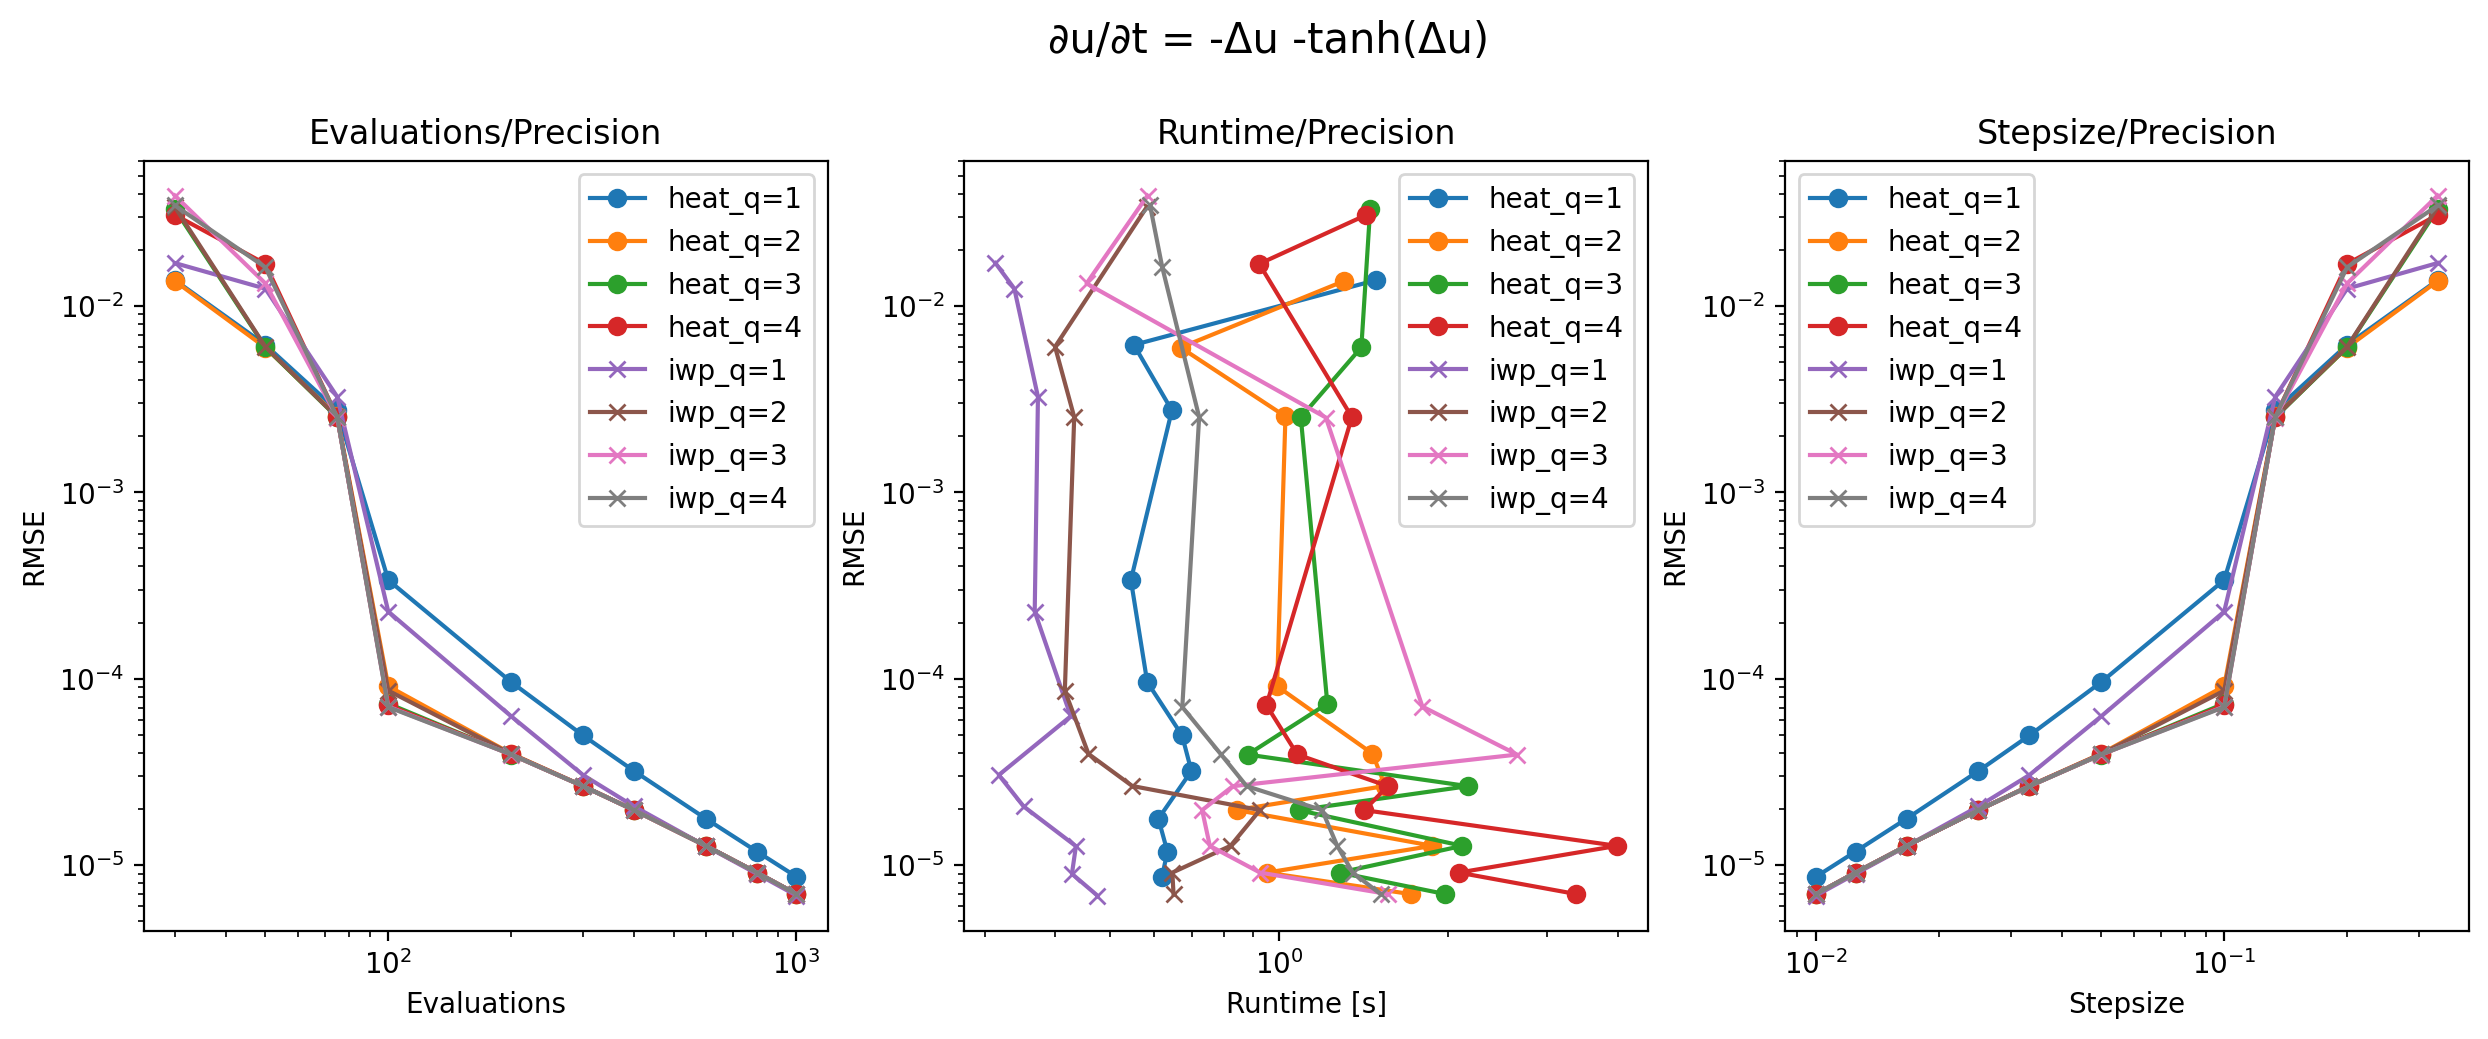

In [2]:
fig, (steps_ax, runtime_ax, stepsize_ax) = plt.subplots(1, 3, dpi=200, figsize=(15, 5))

fig.text(
    0.5,
    1,
    problem_title,
    horizontalalignment="center",
    verticalalignment="center",
    fontsize=15,
)

steps_ax.set_title("Evaluations/Precision")
runtime_ax.set_title("Runtime/Precision")
stepsize_ax.set_title("Stepsize/Precision")

steps_ax.set_ylabel("RMSE")
steps_ax.set_xlabel("Evaluations")

stepsize_ax.set_ylabel("RMSE")
stepsize_ax.set_xlabel("Stepsize")

runtime_ax.set_ylabel("RMSE")
runtime_ax.set_xlabel("Runtime [s]")


for prior, marker in zip(priors, ["o", "x"]):
    for q in derivatives:
        name = f"{prior}_q={q}"
        time_rmse = []
        runtime_rmse = []
        for timestep in timesteps:
            experiment_name = build_experiment_name(prior, q, timestep)
            means, stds, runtime, rmse = get_value(
                f"{prior}_{q}_{timestep}", [None] * 4, dbname
            )
            if means is None or jnp.isnan(means).any():
                continue
            time_rmse.append((timestep, rmse))
            runtime_rmse.append((runtime, rmse))

        steps_ax.plot(*zip(*time_rmse), label=name, marker=marker)
        runtime_ax.plot(*zip(*runtime_rmse), label=name, marker=marker)
        stepsize_ax.plot(
            [10 / time for time, _ in time_rmse],
            [rmse for _, rmse in time_rmse],
            label=name,
            marker=marker,
        )

steps_ax.legend()
steps_ax.loglog()
runtime_ax.legend()
runtime_ax.loglog()
stepsize_ax.legend()
stepsize_ax.loglog()
;

### Calibration plot

prior: heat, q: 1, timestep: 30, chi: 106.47999572753906, log RMSE: -4.289999961853027
prior: heat, q: 2, timestep: 30, chi: 1502.8900146484375, log RMSE: -4.299999713897705
prior: heat, q: 3, timestep: 30, chi: 21.09000015258789, log RMSE: -3.4099998474121094
prior: heat, q: 4, timestep: 30, chi: 65.48999786376953, log RMSE: -3.4800000190734863
prior: iwp, q: 1, timestep: 30, chi: 5.440000057220459, log RMSE: -4.079999923706055
prior: iwp, q: 2, timestep: 30, chi: 3.5299999713897705, log RMSE: -3.379999876022339
prior: iwp, q: 3, timestep: 30, chi: 25.90999984741211, log RMSE: -3.240000009536743
prior: iwp, q: 4, timestep: 30, chi: 57.31999969482422, log RMSE: -3.359999895095825
prior: heat, q: 1, timestep: 50, chi: 63.94999694824219, log RMSE: -5.089999675750732
prior: heat, q: 2, timestep: 50, chi: 1017.1399536132812, log RMSE: -5.119999885559082
prior: heat, q: 3, timestep: 50, chi: 5230.2099609375, log RMSE: -5.119999885559082
prior: heat, q: 4, timestep: 50, chi: 23.7199993133544

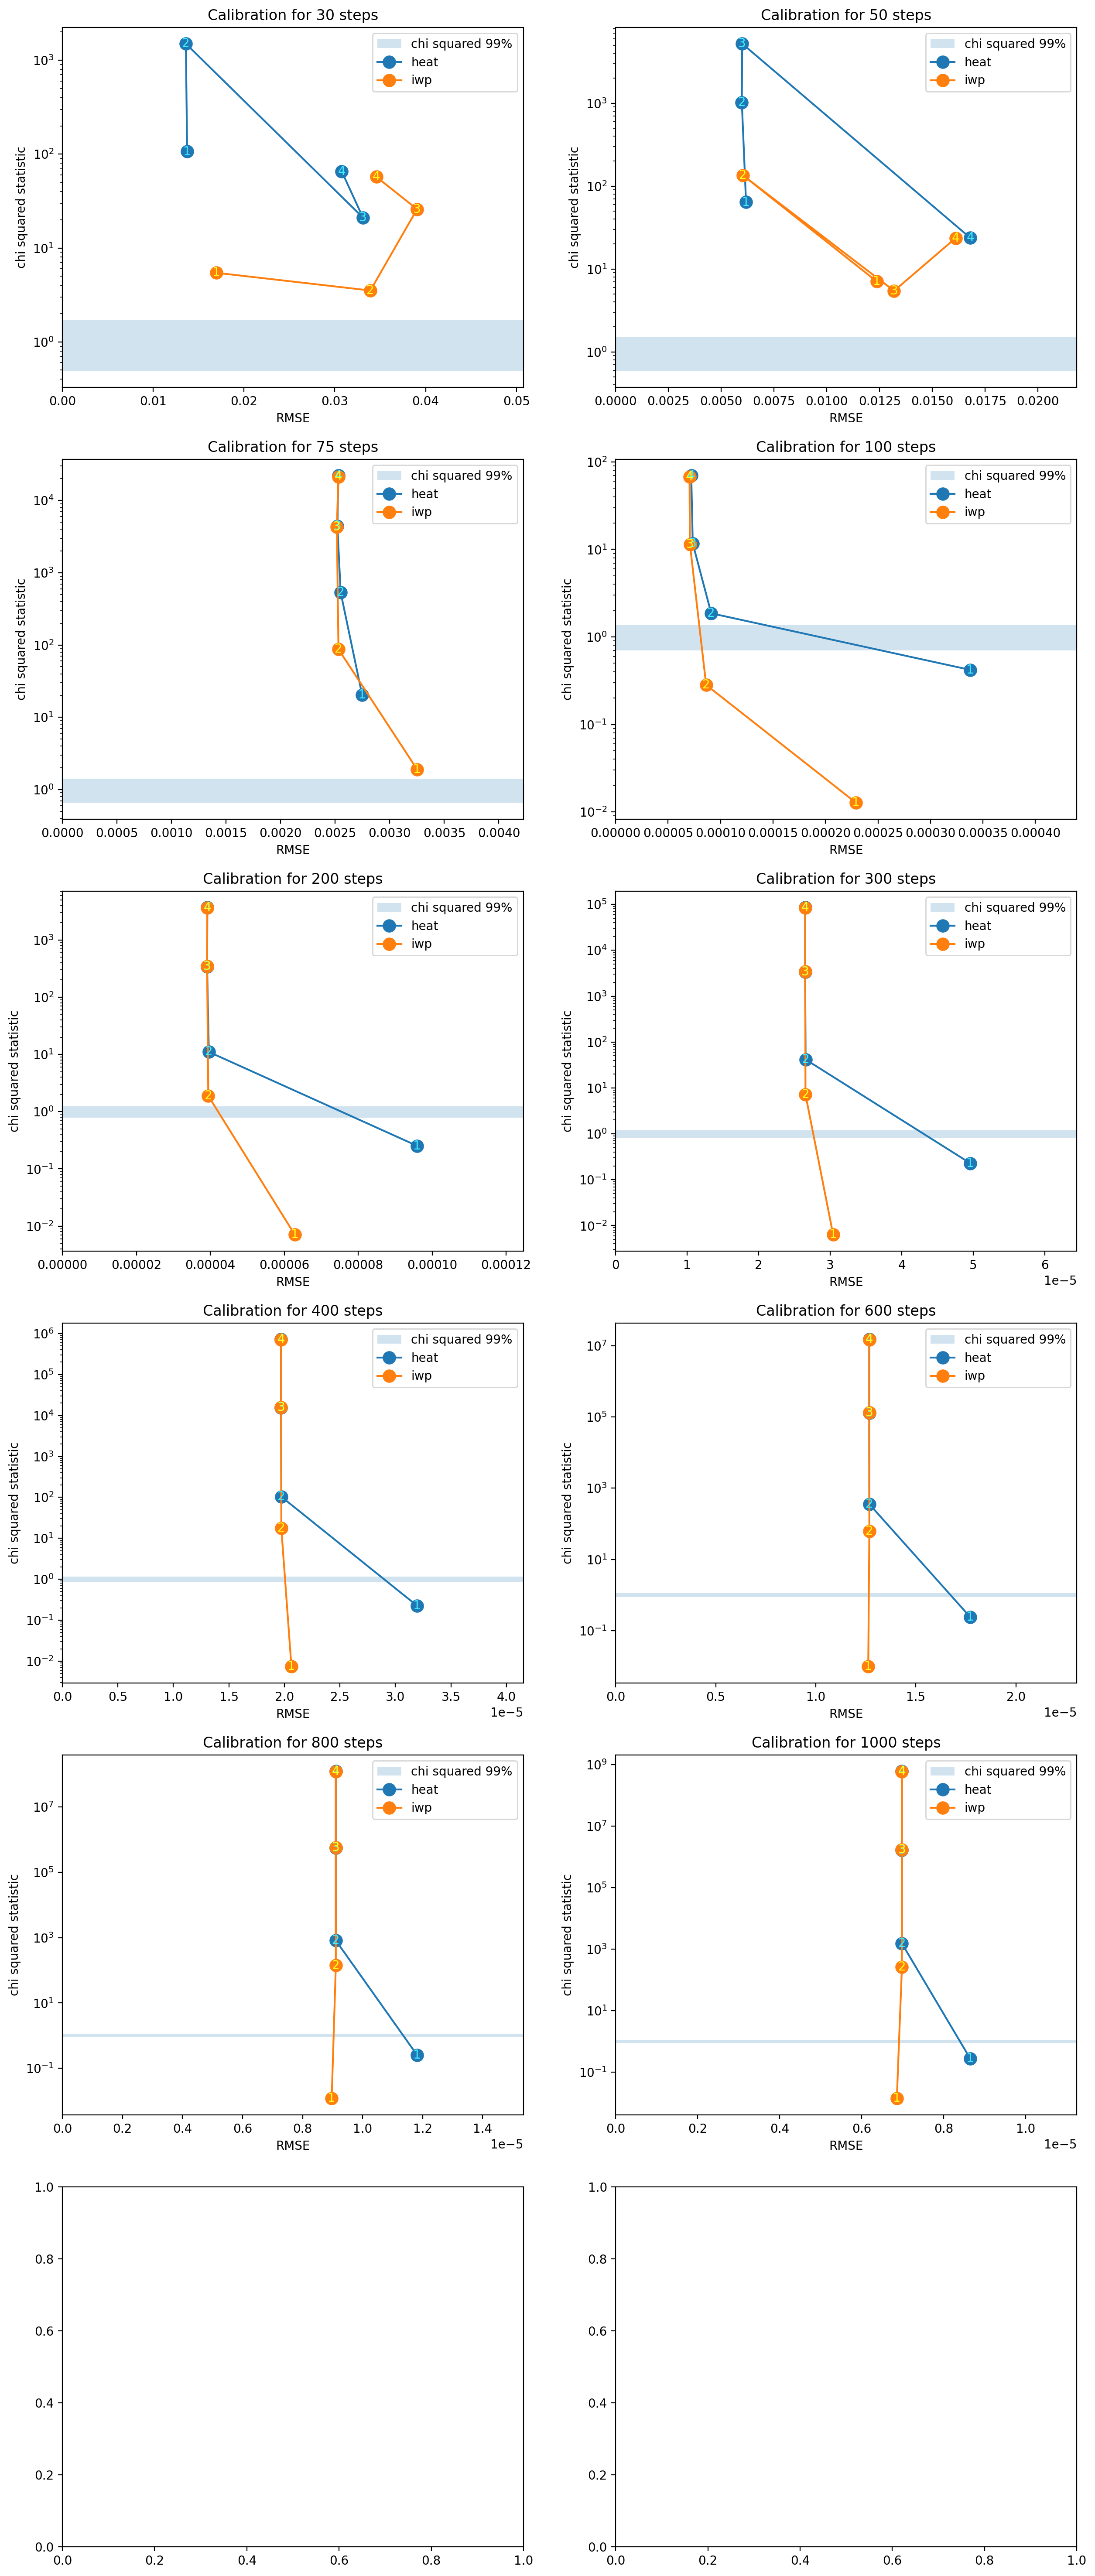

In [3]:
# evalute chi squared statistic
import scipy.stats as stats

# precision / work plot
fig, (ax) = plt.subplots(
    len(timesteps) // 2 + 1, 2, dpi=200, figsize=(15, (len(timesteps) // 2) * 7.5)
)


for eval_axis, timestep in zip(ax.flatten(), timesteps):
    eval_axis.set_title(f"Calibration for {timestep} steps")
    eval_axis.set_ylabel("chi squared statistic")
    eval_axis.set_xlabel("RMSE")
    end = stats.chi2.ppf(0.99, df=timestep - 1) / (timestep - 1)
    start = stats.chi2.ppf(0.01, df=timestep - 1) / (timestep - 1)

    eval_axis.fill_between(
        [0, 1], [start, start], [end, end], alpha=0.2, label="chi squared 99%"
    )

    all_rmses = []
    for prior in priors:
        name = f"{prior}"
        chi_rmse_q = []
        for q in derivatives:
            experiment_name = build_experiment_name(prior, q, timestep)
            means, stds, runtime, rmse = get_value(
                f"{prior}_{q}_{timestep}", [None] * 4, dbname
            )
            if means is None or jnp.isnan(means).any():
                continue

            diff = means - diffrax_sol
            stat = jnp.sum((diff[1:-1] / stds[1:-1]) ** 2)
            print(
                f"prior: {prior}, q: {q}, timestep: {timestep}, chi: {stat.round(2)}, log RMSE: {jnp.log(rmse).round(2)}"
            )

            start = stats.chi2.ppf(0.01, df=98)
            end = stats.chi2.ppf(0.99, df=98)
            chi_rmse_q.append((stat, rmse, q))
            all_rmses.append(rmse)

        if chi_rmse_q == []:
            continue
        text_fix = [-0.0, -0]
        last_plot_color = eval_axis.plot(
            [rmse for (_, rmse, _) in chi_rmse_q],
            [(chi) for (chi, _, _) in chi_rmse_q],
            label=name,
            marker="o",
            markersize=10,
        )[-1].get_color()
        for chi, rmse, q in chi_rmse_q:
            eval_axis.text(
                rmse + text_fix[0],
                chi + text_fix[1],
                q,
                horizontalalignment="center",
                verticalalignment="center",
                color=hex_to_rgb(last_plot_color[1:]),
            )

    eval_axis.set_xlim(0, jnp.max(jnp.array(all_rmses)) * 1.3)
    eval_axis.legend()
    eval_axis.set_yscale("log")

1300.0


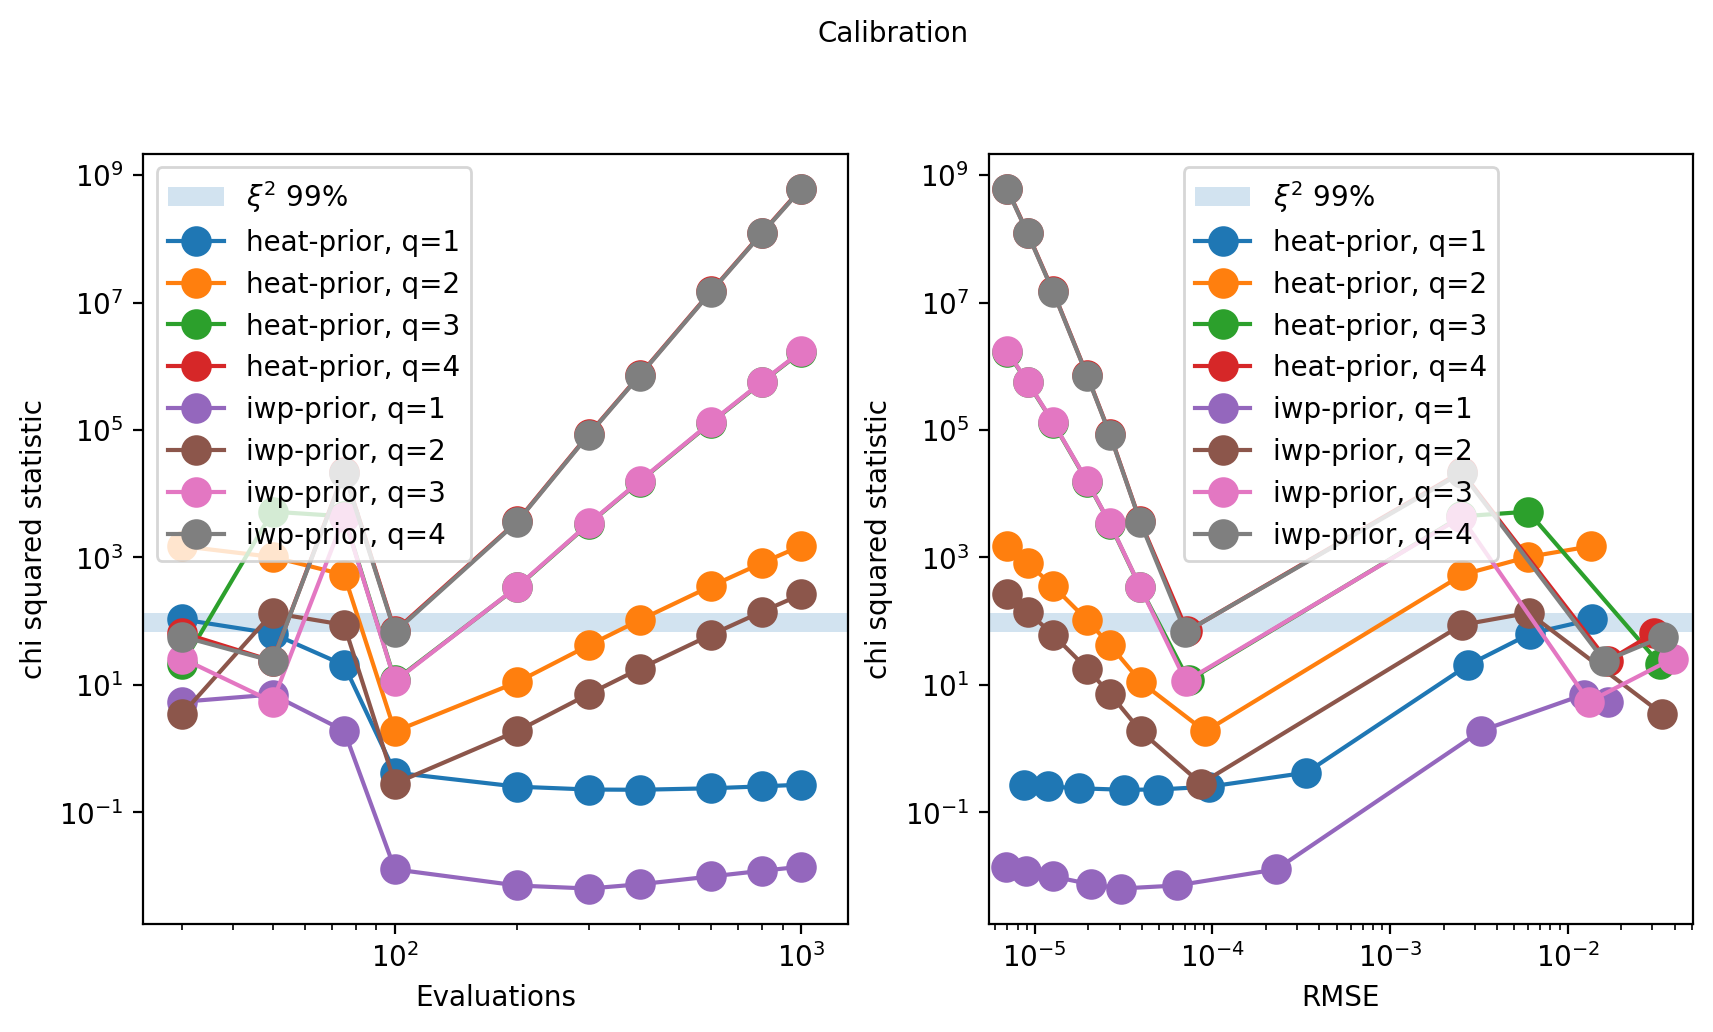

In [4]:
# evalute chi squared statistic
import scipy.stats as stats

# precision / work plot
fig, (eval_axis, rmse_axis) = plt.subplots(1, 2, dpi=200, figsize=(10, 5))

fig.text(
    0.5, 1, "Calibration", horizontalalignment="center", verticalalignment="center"
)

eval_axis.set_ylabel("chi squared statistic")
rmse_axis.set_ylabel("chi squared statistic")

eval_axis.set_xlabel("Evaluations")
rmse_axis.set_xlabel("RMSE")

start = stats.chi2.ppf(0.01, df=98)
end = stats.chi2.ppf(0.99, df=98)
eval_axis.fill_between(
    [0, 1e5], [start, start], [end, end], alpha=0.2, label=r"$\xi^2$ 99%"
)
rmse_axis.fill_between(
    [0, 1e5], [start, start], [end, end], alpha=0.2, label=r"$\xi^2$ 99%"
)

all_rmses = []
all_timesteps = []
for prior in priors:
    name = f"{prior}"
    for q in derivatives:
        chi_rmse_q_time = []

        for timestep in timesteps:
            experiment_name = build_experiment_name(prior, q, timestep)
            means, stds, runtime, rmse = get_value(
                f"{prior}_{q}_{timestep}", [None] * 4, dbname
            )
            if means is None or jnp.isnan(means).any():
                continue

            diff = means - diffrax_sol
            stat = jnp.sum((diff[1:-1] / stds[1:-1]) ** 2)

            chi_rmse_q_time.append((stat, rmse, q, timestep))
            all_rmses.append(rmse)
            all_timesteps.append(timestep)

        if chi_rmse_q_time == []:
            continue

        last_plot_color = eval_axis.plot(
            [timestep for (_, rmse, _, timestep) in chi_rmse_q_time],
            [(chi) for (chi, _, _, _) in chi_rmse_q_time],
            label=f"{name}-prior, q={q}",
            marker="o",
            markersize=10,
        )[-1].get_color()

        last_plot_color = rmse_axis.plot(
            [rmse for (_, rmse, _, _) in chi_rmse_q_time],
            [(chi) for (chi, _, _, _) in chi_rmse_q_time],
            label=f"{name}-prior, q={q}",
            marker="o",
            markersize=10,
        )[-1].get_color()

rmse_axis.set_xlim(
    jnp.min(jnp.array(all_rmses)) * 0.8, jnp.max(jnp.array(all_rmses)) * 1.3
)
eval_axis.set_xlim(
    jnp.min(jnp.array(all_timesteps)) * 0.8, jnp.max(jnp.array(all_timesteps)) * 1.3
)
print(jnp.max(jnp.array(all_timesteps)) * 1.3)
eval_axis.legend()
rmse_axis.legend()
eval_axis.set_yscale("log")
rmse_axis.set_yscale("log")
eval_axis.set_xscale("log")
rmse_axis.set_xscale("log")

### Showing the actual solutions at a fixed spatial point

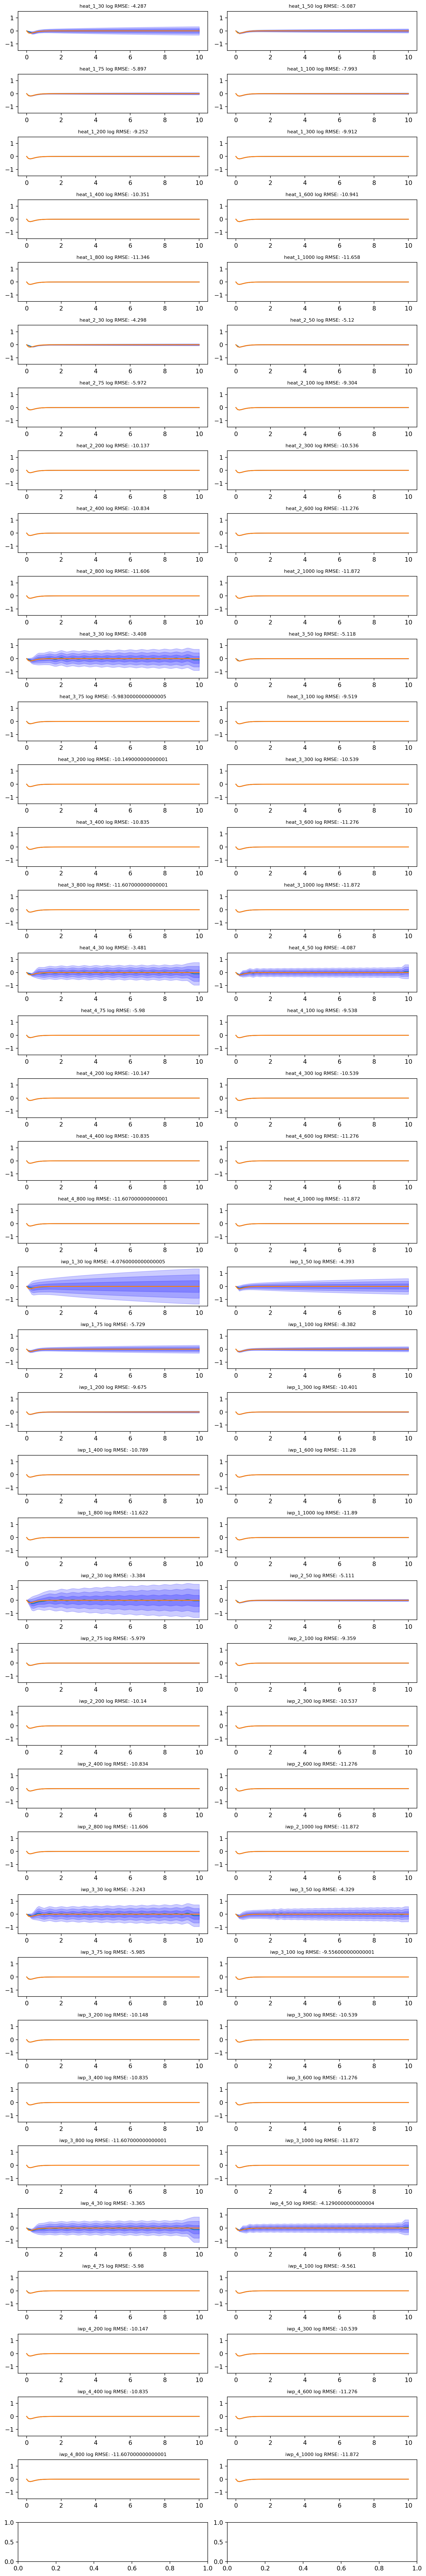

In [5]:
import probabilistic_solve_icosphere

fig, ax = plt.subplots(
    1 + len(product) // 2, 2, dpi=200, figsize=(10, 1.5 * len(product) // 2)
)
fig.tight_layout(pad=5.0)
for i, (prior, q, timestep) in enumerate(product):
    experiment_name = build_experiment_name(prior, q, timestep)
    means, stds, runtime, rmse = get_value(experiment_name, [None] * 4, dbname)
    if means is None:
        continue

    ax.flatten()[i].plot(probabilistic_solve_icosphere.return_times, means, label="EKF")

    def plot_3std(ax, x, means, stds, color):
        ax.fill_between(x, means - stds, means + stds, color=color, alpha=0.2)
        ax.fill_between(x, means - 2 * stds, means + 2 * stds, color=color, alpha=0.2)
        ax.fill_between(x, means - 3 * stds, means + 3 * stds, color=color, alpha=0.2)

    plot_3std(
        ax.flatten()[i], probabilistic_solve_icosphere.return_times, means, stds, "blue"
    )

    ax.flatten()[i].plot(
        probabilistic_solve_icosphere.return_times, diffrax_sol, label="diffrax"
    )
    ax.flatten()[i].set_title(
        f"{experiment_name} log RMSE: {jnp.log(rmse).round(3)}", fontsize=8
    )

    ax.flatten()[i].set_ylim(-1.5, 1.5)

fig.tight_layout()